# Comparative analyses of machine learning-based models
This juptyer notebook goes through the compiling, training, testing and visualisation of machine learning models used for bacterial taxonomy classification using the curated 16S rRNA sequence datasets.

## Loading modules and training variables

In [98]:
# LOADING PACKAGES
import numpy as np
import pandas as pd
import sys
from varname import argname
import time
import os
import glob
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Masking, Dot, Add, BatchNormalization
from keras.layers import MaxPooling1D, AveragePooling1D, Conv1D, Reshape
from keras.layers import TimeDistributed, LSTM, Bidirectional

import wandb
from wandb.keras import WandbCallback

LR, BATCH_SIZE, EPOCHS, MAX_LEN, INPUT_SHAPE_RNN, INPUT_SHAPE_3_MER, INPUT_SHAPE_6_MER = 0.001, 128, 50, 2000, (2000, 4), (125, 1), (15625, 1)

print('Packages loaded!')

Packages loaded!


## Loading and preprocessing the data

In [23]:
# LOADING THE NON-AUGMENTED AND AUGMENTED DATASETS
train_na = pd.read_csv('df_train_0.csv')
val_na = pd.read_csv('df_val_0.csv')
test_na = pd.read_csv('df_test_0.csv')
# ------------------------------------------------
train_a = pd.read_csv('df_train_1.csv')
val_a = pd.read_csv('df_val_1.csv')
# ------------------------------------------------
print('Datasets loaded!')

Datasets loaded!


### Generating k-mers
For use in the Convolutional Neural Networks (CNN), the sequences are processed into a frequency table of k-mers.

In [25]:
from itertools import product
# define all possible k-mers
alphabet = "AGTCN"
tri_mers = [''.join(chars) for chars in product(*(3*(alphabet,)))]
six_mers = [''.join(chars) for chars in product(*(6*(alphabet,)))]

def one_hot_k(sequence, kmers):
    k = len(kmers[0])
    # define a counter dictionary
    kmer_dict = dict.fromkeys(kmers, 0)

    # standardize the sequence
    # by replacing U with T and all ambiguous bases with N
    sequence = sequence.replace('U', 'T').replace('Y', 'N').replace('R', 'N').replace('W', 'N').replace('S', 'N').replace('K', 'N').replace('M', 'N').replace('D', 'N').replace('V', 'N').replace('H', 'N').replace('B', 'N').replace('X', 'N').replace('-', 'N')
    # count every k-mer in the sequence
    for i in range(0, len(sequence) -k+1):
        kmer_dict[sequence[i:i+k]] += 1

    # k-mer frequency array from the dictionary values
    k_array = np.array(list(kmer_dict.values()))
    # normalizing the array by dividing every value with the highest count value
    k_array = k_array / np.amax(k_array)
    return k_array

### One-hot-encoding the sequences
For use in the various Recurrent Neural Networks (RNN), the nucleotide sequences are processed into a one-hot-encoded format.

In [26]:
# Dictionary without consideration of mutation rate (AGTC)
one_hot_dict0 = {'A': [1.,0.,0.,0.], 'G':[0.,1.,0.,0.], 'T':[0.,0.,1.,0.], 'U':[0.,0.,1.,0.], 'C':[0.,0.,0.,1.], 'Y':[0.,0.,0.5,0.5], 'R':[0.5,0.5,0.,0.], 'W':[0.5,0.,0.5,0.], 'S':[0.,0.5,0.,0.5], 'K':[0.,0.5,0.5,0.], 'M':[0.5,0.,0.,0.5], 'D':[0.33,0.33,0.33,0.], 'V':[0.33,0.33,0.,0.33], 'H':[0.33,0.,0.33,0.33], 'B':[0.,0.33,0.33,0.33], 'X':[0.25,0.25,0.25,0.25], 'N':[0.25,0.25,0.25,0.25], '-':[0.,0.,0.,0.]}
# Dictionary with consideration of mutation rate (AGTC)
one_hot_dict1 = {'A': [1.,0.,-0.5,-0.5], 'G':[0.,1.,-0.5,-0.5], 'T':[-0.5,-0.5,1.,0.], 'U':[-0.5,-0.5,1.,0.], 'C':[-0.5,-0.5,0.,1.], 'Y':[-0.5,-0.5,0.5,0.5], 'R':[0.5,0.5,-0.5,-0.5], 'W':[0.5,-0.5,0.5,-0.5], 'S':[-0.5,0.5,-0.5,0.5], 'K':[-0.5,0.5,0.5,-0.5], 'M':[0.5,-0.5,-0.5,0.5], 'D':[0.33,0.33,0.33,-1.], 'V':[0.33,0.33,-1.,0.33], 'H':[0.33,-1.,.33,0.33], 'B':[-1.,0.33,0.33,0.33], 'X':[0.,0.,0.,0.], 'N':[0.,0.,0.,0.], '-':[0.,0.,0.,0.]}

def one_hot_seq(sequence, one_hot_dict, MAX_LEN=MAX_LEN):
    # padding the sequences to a fixed length
	sequence += '-'*(MAX_LEN - len(sequence))
    # generating list of one-hot-lists using the dictionary
	onehot_encoded = [one_hot_dict[nucleotide] for nucleotide in sequence]
    # returning the list of lists as a numpy array
	return np.array(onehot_encoded)

### One-hot-encoding the labels
For use in the deep learning models, the labels are processed into a one-hot-encoding format. To achieve this, every unique label is first encoded to a numerical value.

In [27]:
def get_taxon_dict(df, taxon):
    # listing all unique taxon labels
    taxon_list = list(df[taxon].unique())

    # generating a dictionary to associate every unique taxon to a number
    taxon_dict = dict(zip(taxon_list, range(0, len(taxon_list))))
    # and the reversed dictionary as a lookup table
    taxon_dict_lookup = {v: k for k, v in taxon_dict.items()}

    return taxon_dict, taxon_dict_lookup

## Generating the input sequences and labels
The encoding methods for nucleotide sequences (x) defined earlier are now applied. The labels (y) are one-hot-encoded using the to_categorical function in keras_utils, thereby, converting the data into the correct format for feeding it to the deep learning models.

Every array is saved to reduce memory requirements down the road.

### Encoding the sequences into k-mer counts and one-hot-encoded sequences

In [28]:
# ENCODING SEQUENCES for the CNN models in 2 processing variations
# FOR CNN  |  with 3-mer
x_train_CNN_na3 = np.array(train_na['Sequence'].apply(lambda x: one_hot_k(x, tri_mers)).tolist())
np.save('arrays/CNN/x_train_CNN_na3.npy', x_train_CNN_na3)

# x_train_CNN_a3 = np.array(train_a['Sequence'].apply(lambda x: one_hot_k(x, tri_mers)).tolist())
# np.save('arrays/CNN/x_train_CNN_a3.npy', x_train_CNN_a3)

x_test_CNN_na3 = np.array(test_na['Sequence'].apply(lambda x: one_hot_k(x, tri_mers)).tolist())
np.save('arrays/CNN/x_test_CNN_na3.npy', x_test_CNN_na3)

dataval_CNN_na3 = np.array(val_na['Sequence'].apply(lambda x: one_hot_k(x, tri_mers)).tolist())
np.save('arrays/CNN/dataval_CNN_na3.npy', dataval_CNN_na3)

# dataval_CNN_a3 = np.array(val_a['Sequence'].apply(lambda x: one_hot_k(x, tri_mers)).tolist())
# np.save('arrays/CNN/dataval_CNN_a3.npy', dataval_CNN_a3)
print('3-mer complete')
# -----------------------------------------------------------------------------------------------------
# FOR CNN  |  with 6-mer
x_train_CNN_na6 = np.array(train_na['Sequence'].apply(lambda x: one_hot_k(x, six_mers)).tolist())
np.save('arrays/CNN/x_train_CNN_na6.npy', x_train_CNN_na6)

x_train_CNN_a6 = np.array(train_a['Sequence'].apply(lambda x: one_hot_k(x, six_mers)).tolist())
np.save('arrays/CNN/x_train_CNN_a6.npy', x_train_CNN_a6)

x_test_CNN_na6 = np.array(test_na['Sequence'].apply(lambda x: one_hot_k(x, six_mers)).tolist())
np.save('arrays/CNN/x_test_CNN_na6.npy', x_test_CNN_na6)

dataval_CNN_na6 = np.array(val_na['Sequence'].apply(lambda x: one_hot_k(x, six_mers)).tolist())
np.save('arrays/CNN/dataval_CNN_na6.npy', dataval_CNN_na6)

dataval_CNN_a6 = np.array(val_a['Sequence'].apply(lambda x: one_hot_k(x, six_mers)).tolist())
np.save('arrays/CNN/dataval_CNN_a6.npy', dataval_CNN_a6)
print('6-mer complete')
# -----------------------------------------------------------------------------------------------------
print('CNN sequences complete')

3-mer complete
6-mer complete
CNN sequences complete


In [11]:
# ENCODING SEQUENCES for the RNN models in 2 processing variations
# FOR RNN  |  with regular one-hot-encoding
x_train_RNN_na0 = np.array(train_na['Sequence'].apply(lambda x: one_hot_seq(x, one_hot_dict0)).tolist())
np.save('arrays/RNN/x_train_RNN_na0.npy', x_train_RNN_na0)

# x_train_RNN_a0 = np.array(train_a['Sequence'].apply(lambda x: one_hot_seq(x, one_hot_dict0)).tolist())
# np.save('arrays/RNN/x_train_RNN_a0.npy', x_train_RNN_a0)

x_test_RNN_na0 = np.array(test_na['Sequence'].apply(lambda x: one_hot_seq(x, one_hot_dict0)).tolist())
np.save('arrays/RNN/x_test_RNN_na0.npy', x_test_RNN_na0)

dataval_RNN_na0 = np.array(val_na['Sequence'].apply(lambda x: one_hot_seq(x, one_hot_dict0)).tolist())
np.save('arrays/RNN/dataval_RNN_na0.npy', dataval_RNN_na0)

# dataval_RNN_a0 = np.array(val_a['Sequence'].apply(lambda x: one_hot_seq(x, one_hot_dict0)).tolist())
# np.save('arrays/RNN/dataval_RNN_a0.npy', dataval_RNN_a0)
print('Regular one-hot-encoding complete')
# -----------------------------------------------------------------------------------------------------
# FOR RNN  |  with matation rate adjusted one-hot-encoding
x_train_RNN_na1 = np.array(train_na['Sequence'].apply(lambda x: one_hot_seq(x, one_hot_dict1)).tolist())
np.save('arrays/RNN/x_train_RNN_na1.npy', x_train_RNN_na1)

x_train_RNN_a1 = np.array(train_a['Sequence'].apply(lambda x: one_hot_seq(x, one_hot_dict1)).tolist())
np.save('arrays/RNN/x_train_RNN_a1.npy', x_train_RNN_a1)

x_test_RNN_na1 = np.array(test_na['Sequence'].apply(lambda x: one_hot_seq(x, one_hot_dict1)).tolist())
np.save('arrays/RNN/x_test_RNN_na1.npy', x_test_RNN_na1)

dataval_RNN_na1 = np.array(val_na['Sequence'].apply(lambda x: one_hot_seq(x, one_hot_dict1)).tolist())
np.save('arrays/RNN/dataval_RNN_na1.npy', dataval_RNN_na1)

dataval_RNN_a1 = np.array(val_a['Sequence'].apply(lambda x: one_hot_seq(x, one_hot_dict1)).tolist())
np.save('arrays/RNN/dataval_RNN_a1.npy', dataval_RNN_a1)
print('Mutations rate adjusted one-hot-encoding complete')
# -----------------------------------------------------------------------------------------------------
print('RNN sequences complete')

Regular one-hot-encoding complete
Mutations rate adjusted one-hot-encoding complete
RNN sequences complete


### Encoding the labels into a one-hot-encoded format at Family level

In [10]:
taxon = 'Family'
taxon_dict = get_taxon_dict(test_na, taxon)[0]

# Associate every entry's label in the df to a number 
#   using the dictionary & one-hot encode the numerical labels
y_train_fam_na = to_categorical(y=train_na[taxon].map(taxon_dict).astype(np.float32))
np.save('arrays/family/y_train_fam_na.npy', y_train_fam_na)

# y_train_fam_a = to_categorical(y=train_a[taxon].map(taxon_dict).astype(np.float32))
# np.save('arrays/family/y_train_fam_a.npy', y_train_fam_a)

y_test_fam_na = to_categorical(y=test_na[taxon].map(taxon_dict).astype(np.float32))
np.save('arrays/family/y_test_fam_na.npy', y_test_fam_na)

labelsval_fam_na = to_categorical(y=val_na[taxon].map(taxon_dict).astype(np.float32))
np.save('arrays/family/labelsval_fam_na.npy', labelsval_fam_na)

# labelsval_fam_a = to_categorical(y=val_a[taxon].map(taxon_dict).astype(np.float32))
# np.save('arrays/family/labelsval_fam_a.npy', labelsval_fam_a)
print('Family label arrays generated')
# ------------------------------------------------------------------------------------
fam_count = train_na[taxon].nunique()
print(f'The number of unique family labels: {fam_count}')

Labels complete
Family train/test/val arrays generated
The number of unique family labels: 349


### Encoding the labels into a one-hot-encoded format at Genus level

In [13]:
taxon = 'Genus'
taxon_dict = get_taxon_dict(test_na, taxon)[0]

y_train_gen_na = to_categorical(y=train_na[taxon].map(taxon_dict).astype(np.float32))
np.save('arrays/genus/y_train_gen_na.npy', y_train_gen_na)

y_train_gen_a = to_categorical(y=train_a[taxon].map(taxon_dict).astype(np.float32))
np.save('arrays/genus/y_train_gen_a.npy', y_train_gen_a)

y_test_gen_na = to_categorical(y=test_na[taxon].map(taxon_dict).astype(np.float32))
np.save('arrays/genus/y_test_gen_na.npy', y_test_gen_na)

labelsval_gen_na = to_categorical(y=val_na[taxon].map(taxon_dict).astype(np.float32))
np.save('arrays/genus/labelsval_gen_na.npy', labelsval_gen_na)

labelsval_gen_a = to_categorical(y=val_a[taxon].map(taxon_dict).astype(np.float32))
np.save('arrays/genus/labelsval_gen_a.npy', labelsval_gen_a)
print('Genus label arrays generated')
# ------------------------------------------------------------------------------------
gen_count = train_na[taxon].nunique()
print(f'The number of unique genus labels: {gen_count}')

Genus label arrays generated
The number of unique genus labels: 954


### Encoding the labels into a one-hot-encoded format at Species level

In [12]:
taxon = 'Species'
taxon_dict = get_taxon_dict(test_na, taxon)[0]

y_train_spe_na = to_categorical(y=train_na[taxon].map(taxon_dict).astype(np.float32))
np.save('arrays/species/y_train_spe_na.npy', y_train_spe_na)

# y_train_spe_a = to_categorical(y=train_a[taxon].map(taxon_dict).astype(np.float32))
# np.save('arrays/species/y_train_spe_a.npy', y_train_spe_a)

y_test_spe_na = to_categorical(y=test_na[taxon].map(taxon_dict).astype(np.float32))
np.save('arrays/species/y_test_spe_na.npy', y_test_spe_na)

labelsval_spe_na = to_categorical(y=val_na[taxon].map(taxon_dict).astype(np.float32))
np.save('arrays/species/labelsval_spe_na.npy', labelsval_spe_na)

# labelsval_spe_a = to_categorical(y=val_a[taxon].map(taxon_dict).astype(np.float32))
# np.save('arrays/species/labelsval_spe_a.npy', labelsval_spe_a)
print('Species label arrays generated')
# ------------------------------------------------------------------------------------
spe_count = train_na[taxon].nunique()
print(f'The number of unique species labels: {spe_count}')

Species train/test/val arrays generated
The number of unique species labels: 1569


## Loading the generated training/validation/testing arrays
When seperating the processing and training/evaluation scripts, due to memory limits, the saved arrays can be loaded using this script.

In [ ]:
# AMOUNT OF UNIQUE LABELS AT EACH TAXON LEVEL
fam_count, gen_count, spe_count = 349, 954, 1569

# LOADING ENCODED SEQUENCES for the CNN models in 2 processing variations
# FOR CNN  |  with 3-mer
x_train_CNN_na3 = np.load('arrays/CNN/x_train_CNN_na3.npy')
# x_train_CNN_a3 = np.load('arrays/CNN/x_train_CNN_a3.npy')
x_test_CNN_na3 = np.load('arrays/CNN/x_test_CNN_na3.npy')
dataval_CNN_na3 = np.load('arrays/CNN/dataval_CNN_na3.npy')
# dataval_CNN_a3 = np.load('arrays/CNN/dataval_CNN_a3.npy')
print('3-mers LOADED')
# -----------------------------------------------------------------------------
# FOR CNN  |  with 6-mer
x_train_CNN_na6 = np.load('arrays/CNN/x_train_CNN_na6.npy')
x_train_CNN_a6 = np.load('arrays/CNN/x_train_CNN_a6.npy')
x_test_CNN_na6 = np.load('arrays/CNN/x_test_CNN_na6.npy')
dataval_CNN_na6 = np.load('arrays/CNN/dataval_CNN_na6.npy')
dataval_CNN_a6 = np.load('arrays/CNN/dataval_CNN_a6.npy')
print('6-mers LOADED')
# -----------------------------------------------------------------------------
print('CNN sequences LOADED')

###############################################################################

# LOADING ENCODED SEQUENCES for the RNN models in 2 processing variations
# FOR RNN  |  with regular one-hot-encoding
x_train_RNN_na0 = np.load('arrays/RNN/x_train_RNN_na0.npy')
# x_train_RNN_a0 = np.load('arrays/RNN/x_train_RNN_a0.npy')
x_test_RNN_na0 = np.load('arrays/RNN/x_test_RNN_na0.npy')
dataval_RNN_na0 = np.load('arrays/RNN/dataval_RNN_na0.npy')
# dataval_RNN_a0 = np.load('arrays/RNN/dataval_RNN_a0.npy')
print('Regular one-hot-encoded sequences LOADED')
# -----------------------------------------------------------------------------
# FOR RNN  |  with matation rate adjusted one-hot-encoding
x_train_RNN_na1 = np.load('arrays/RNN/x_train_RNN_na1.npy')
x_train_RNN_a1 = np.load('arrays/RNN/x_train_RNN_a1.npy')
x_test_RNN_na1 = np.load('arrays/RNN/x_test_RNN_na1.npy')
dataval_RNN_na1 = np.load('arrays/RNN/dataval_RNN_na1.npy')
dataval_RNN_a1 = np.load('arrays/RNN/dataval_RNN_a1.npy')
print('Mutation rate adjusted one-hot-encoded sequences LOADED')
# -----------------------------------------------------------------------------
print('RNN sequences LOADED')

###############################################################################

# LOADING one-hot encoded labels at each taxon level
# -----------------------------------------------------------------------------
# LABELS AT FAMILY LEVEL
y_train_fam_na = np.load('arrays/family/y_train_fam_na.npy')
# y_train_fam_a = np.load('arrays/family/y_train_fam_a.npy')
y_test_fam_na = np.load('arrays/family/y_test_fam_na.npy')
labelsval_fam_na = np.load('arrays/family/labelsval_fam_na.npy')
# labelsval_fam_a = np.load('arrays/family/labelsval_fam_a.npy')
print('Family label arrays LOADED')
# -----------------------------------------------------------------------------
# LABELS AT GENUS LEVEL
y_train_gen_na = np.load('arrays/genus/y_train_gen_na.npy')
y_train_gen_a = np.load('arrays/genus/y_train_gen_a.npy')
y_test_gen_na = np.load('arrays/genus/y_test_gen_na.npy')
labelsval_gen_na = np.load('arrays/genus/labelsval_gen_na.npy')
labelsval_gen_a = np.load('arrays/genus/labelsval_gen_a.npy')
print('Genus label arrays LOADED')
# -----------------------------------------------------------------------------
# LABELS AT SPECIES LEVEL
y_train_spe_na = np.load('arrays/species/y_train_spe_na.npy')
# y_train_spe_a = np.load('arrays/species/y_train_spe_a.npy')
y_test_spe_na = np.load('arrays/species/y_test_spe_na.npy')
labelsval_spe_na = np.load('arrays/species/labelsval_spe_na.npy')
# labelsval_spe_a = np.load('arrays/species/labelsval_spe_a.npy')
print('Species label arrays LOADED')

## Setting up the network architectures
What follows are a set of functions for creating the deep learning models.

### 1. Convolutional Neural Network (CNN)

In [107]:
# CNN
def make_CNNmodel(input_shape, out_len, name='CNN'):
    CNNmodel = keras.Sequential(
        [
            Reshape(target_shape = input_shape, input_shape = input_shape[:-1]),
            Conv1D(4, 15, input_shape=input_shape),
            Activation('relu'),
            MaxPooling1D(pool_size=2),

            Conv1D(8, 10),
            Activation('relu'),
            MaxPooling1D(pool_size=2),

            Conv1D(12, 5),
            Activation('relu'),
            MaxPooling1D(pool_size=2),
            Dropout(0.2),

            Flatten(),
            Dense(256),
            Activation('relu'),
            Dropout(0.4),

            Dense(out_len, activation='softmax')
        ], 
        name = name
    )
    return CNNmodel

### 2. Bidirectional Long-Short Term Memory Neural Network (BiLSTM)

In [30]:
# BiLSTM
def make_BiLSTMmodel(out_len, INPUT_SHAPE=INPUT_SHAPE_RNN, name='BiLSTM'):
    BiLSTMmodel = keras.Sequential(
        [
            Masking(mask_value=0., input_shape=INPUT_SHAPE_RNN),
            
            Bidirectional(LSTM(128, return_sequences=True), merge_mode='sum'),
            Dropout(0.5),

            AveragePooling1D(4),
            Bidirectional(LSTM(128), merge_mode='sum'),
            Dropout(0.5),

            Dense((out_len), activation='softmax'),
        ],
        name=name
    )
    return BiLSTMmodel

### 3. Convolutional BiLSTM Neural Network (ConvBiLSTM)

In [103]:
# ConvBiLSTM
def make_ConvBiLSTMmodel(out_len, INPUT_SHAPE=INPUT_SHAPE_RNN, name='ConvBiLSTM'):
    ConvBiLSTMmodel = keras.Sequential(
        [
            Masking(mask_value=0., input_shape=INPUT_SHAPE),
                        
            Conv1D(128, 3, padding='same'),
            AveragePooling1D(),

            Conv1D(128, 3, padding='same'),
            AveragePooling1D(),

            Conv1D(128, 3, padding='same', use_bias=True),
            AveragePooling1D(),
            Dropout(0.4),
            
            Bidirectional(LSTM(128, activation='tanh'), merge_mode='sum'),
            Dropout(0.2),
            
            Dense(128, activation='relu'),
            Dropout(0.2),
            Dense(out_len, activation='softmax')
        ], 
        name = name
    )
    return ConvBiLSTMmodel

### 4. Attention-based ConvBiLSTM (Read2Pheno)

In [32]:
# Read2Pheno
## Conv & Res net layers
CONV_NET_nr, RES_NET_nr, NET_filters, NET_window = 2, 1, 64, 2
## extra Dropout layer (after Res block)
DROP_r, POOL_s = 0.2, 2
## BiLSTM layer
LSTM_nodes = 128
## attention Layers
ATT_layers, ATT_nodes = 1, 128
## fully connected layers
FC_layers, FC_nodes, FC_drop = 1, 128, 0.3

#####################################################################################################
# BLOCK FUNCTIONS
def conv_net_block(X, n_cnn_filters=256, cnn_window=9, block_name='convblock'):
    '''
    convolutional block with a 1D convolutional layer, a batch norm layer followed by a relu activation.
    parameters:
        n_cnn_filters: number of output channels
        cnn_window: window size of the 1D convolutional layer
    '''
    X = Conv1D(n_cnn_filters, cnn_window, strides=1, padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    return X

def res_net_block(X, n_cnn_filters=256, cnn_window=9, block_name='resblock'):
    '''
    residual net block accomplished by a few convolutional blocks.
    parameters:
        n_cnn_filters: number of output channels
        cnn_window: window size of the 1D convolutional layer
    '''
    X_identity = X
    # cnn0
    X = Conv1D(n_cnn_filters, cnn_window, strides=1, padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    # cnn1
    X = Conv1D(n_cnn_filters, cnn_window, strides=1, padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    # cnn2
    X = Conv1D(n_cnn_filters, cnn_window, strides=1, padding='same')(X)
    X = BatchNormalization()(X)
    X = Add()([X, X_identity])
    X = Activation('relu')(X)
    return X

def attention_layer(H_lstm, n_layer, n_node, block_name='att'):
    '''
    feedforward attention layer accomplished by time distributed dense layers.
    parameters:
        n_layer: number of hidden layers
        n_node: number of hidden nodes
    '''
    H_emb = H_lstm
    for i in range(n_layer):
        H_lstm = TimeDistributed(Dense(n_node, activation="tanh"))(H_lstm)
    M = TimeDistributed(Dense(1, activation="linear"))(H_lstm)
    alpha = keras.layers.Softmax(axis=1)(M)
    r_emb = Dot(axes = 1)([alpha, H_emb])
    r_emb = Flatten()(r_emb)
    return r_emb

def fully_connected(r_emb, n_layer, n_node, drop_out_rate=0.5, block_name='fc'):
    '''
    fully_connected layer consists of a few dense layers.
    parameters:
        n_layer: number of hidden layers
        n_node: number of hidden nodes
        drop_out_rate: dropout rate to prevent the model from overfitting
    '''
    for i in range(n_layer):
        r_emb = Dense(n_node, activation="relu")(r_emb)
    r_emb = Dropout(drop_out_rate)(r_emb) 
    return r_emb
    
#####################################################################################################
# TOTAL MODEL FUNCTION

def make_R2Pmodel(out_len, INPUT_SHAPE=INPUT_SHAPE_RNN, name='Read2Pheno'):
    X = Input(shape=INPUT_SHAPE)
    X_mask = Masking(mask_value=0.)(X)

    ## CONV Layers
    X_cnn = X_mask
    # conv_net
    for i in range(CONV_NET_nr):
        X_cnn = conv_net_block(X_cnn, n_cnn_filters=NET_filters, cnn_window=NET_window)
    # res_net
    for i in range(RES_NET_nr):
        X_cnn = res_net_block(X_cnn, n_cnn_filters=NET_filters, cnn_window=NET_window)

    ## Extra Pooling layer and Dropout
    X_pool = AveragePooling1D(pool_size=POOL_s)(X_cnn)
    X_drop = Dropout(DROP_r)(X_pool)

    ## RNN Layers
    H_lstm = Bidirectional(LSTM(LSTM_nodes, return_sequences=True), merge_mode='sum')(X_drop)
    H_lstm = Activation('tanh')(H_lstm)

    ## ATT Layers
    r_emb = attention_layer(H_lstm, n_layer=ATT_layers, n_node=ATT_nodes, block_name = 'att')
        
    # Fully connected layers
    r_emb = fully_connected(r_emb, n_layer=FC_layers, n_node=FC_nodes, drop_out_rate=FC_drop, block_name = 'fc')

    # Compile model
    out = Dense(out_len, activation='softmax', name='final_dense')(r_emb)
    R2Pmodel = Model(inputs = X, outputs = out, name = name)
    
    return R2Pmodel

## Creating the Deep Learning models
The models are generated based on input and output shapes.

### 1. CNN
The CNN models are created, tailored to the different input (k-mer) and output (taxon) shapes. The input is determined by the k-mer used and the output shape is determined by the amount of unique taxon labels.

In [33]:
# for Family
CNN_fam_3 = make_CNNmodel(input_shape=INPUT_SHAPE_3_MER, out_len=fam_count, name='CNN_fam_3') # with 3-mer
CNN_fam_6 = make_CNNmodel(input_shape=INPUT_SHAPE_6_MER, out_len=fam_count, name='CNN_fam_6') # with 6-mer
# for Genus
CNN_gen_3 = make_CNNmodel(input_shape=INPUT_SHAPE_3_MER, out_len=gen_count, name='CNN_gen_3')
CNN_gen_6 = make_CNNmodel(input_shape=INPUT_SHAPE_6_MER, out_len=gen_count, name='CNN_gen_6')
# for Species
CNN_spe_3 = make_CNNmodel(input_shape=INPUT_SHAPE_3_MER, out_len=spe_count, name='CNN_spe_3')
CNN_spe_6 = make_CNNmodel(input_shape=INPUT_SHAPE_6_MER, out_len=spe_count, name='CNN_spe_6')

### 2. RNN
The RNN models are created, tailored to the different output shapes. The output shape is determined by the amount of unique taxon labels.

In [34]:
# for Family
BiLSTM_fam = make_BiLSTMmodel(out_len=fam_count, name='BiLSTM_fam')
ConvBiLSTM_fam = make_ConvBiLSTMmodel(out_len=fam_count, name='ConvBiLSTM_fam')
R2P_fam = make_R2Pmodel(out_len=fam_count, name='R2P_fam')
# for Genus
BiLSTM_gen = make_BiLSTMmodel(out_len=gen_count, name='BiLSTM_gen')
ConvBiLSTM_gen = make_ConvBiLSTMmodel(out_len=gen_count, name='ConvBiLSTM_gen')
R2P_gen = make_R2Pmodel(out_len=gen_count, name='R2P_gen')
# for Species
BiLSTM_spe = make_BiLSTMmodel(out_len=spe_count, name='BiLSTM_spe')
ConvBiLSTM_spe = make_ConvBiLSTMmodel(out_len=spe_count, name='ConvBiLSTM_spe')
R2P_spe = make_R2Pmodel(out_len=spe_count, name='R2P_spe')

## Compiling, Training and Evaluating the Deep Learning models

For each model:
- a Weights and Biases run is initiated
- the model is compiled and a summary is printed
- the model is trained and training-time is measured
- the model is evaluated by calculating the test-loss and -accuracy, the F1 score and the MCC score
- the training history and metrics are saved

In [35]:
def train_and_evaluate_model(model, train_data, train_labels, validation_data, validation_labels, test_data, test_labels):
    wandb.init(project = 'Final Training', entity = 'bachelorprojectgroup9', name=model.name)

    print (f'Loading {model.name} model...')
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=LR), metrics=['accuracy'])
    print(model.summary())

    print (f'Fitting {model.name} model...')
    start_time = time.time()
    history = model.fit(train_data, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data = (validation_data, validation_labels), callbacks=[WandbCallback()])
    time_taken = round(time.time() - start_time)
    # history object is saved and can later be destinguished using the model/train_data names
    np.save('history/{}_{}.npy'.format(model.name, argname('train_data')), history.history)
    
    print (f'Evaluating {model.name} model...')
    test_labels_arg = np.argmax(test_labels, axis=1)
    test_predictions = np.argmax(model.predict(test_data), axis=1)
    loss, accuracy = model.evaluate(test_data, test_labels)

    # F1-score: harmonic mean of the precision and recall
    #   score from 0 to 1
    f1 = f1_score(y_true=test_labels_arg, y_pred=test_predictions, average='weighted')
    # Matthews correlation coefficient: coefficient of +1 represents a perfect prediction,
    #   0 an average random prediction and -1 an inverse prediction
    mcc = matthews_corrcoef(y_true=test_labels_arg, y_pred=test_predictions)

    score_dict = pd.DataFrame({'Model/run' : model.name, 'Data' : argname('train_data'), 'Training time' : time_taken, 'Test loss' : loss, 'Test accuracy' : accuracy, 'F1-score' : f1, 'MCC' : mcc}, index=[0])
    print(score_dict)
    # score metrics are saved and can later be destinguished using the model names
    score_dict.to_csv(f'scores/{model.name}_evaluation.csv', index=False)

    wandb.finish()
    return

In [ ]:
# RUNNING CNN MODELS
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# running the model at genus level with both k-mers
train_and_evaluate_model(CNN_gen_3, x_train_CNN_na3, y_train_gen_na, dataval_CNN_na3, labelsval_gen_na, x_test_CNN_na3, y_test_gen_na)
train_and_evaluate_model(CNN_gen_6, x_train_CNN_na6, y_train_gen_na, dataval_CNN_na6, labelsval_gen_na, x_test_CNN_na6, y_test_gen_na)
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# running the 6-mer model at family and species level
train_and_evaluate_model(CNN_fam_6, x_train_CNN_na6, y_train_fam_na, dataval_CNN_na6, labelsval_fam_na, x_test_CNN_na6, y_test_fam_na)
train_and_evaluate_model(CNN_spe_6, x_train_CNN_na6, y_train_spe_na, dataval_CNN_na6, labelsval_spe_na, x_test_CNN_na6, y_test_spe_na)
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# running the 6-mer model at genus level on the augmented data
train_and_evaluate_model(CNN_gen_6, x_train_CNN_a6, y_train_gen_a, dataval_CNN_a6, labelsval_gen_a, x_test_CNN_na6, y_test_gen_na)

###################################################################################################################################################################################################

# RUNNING RNN MODELS
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# running the models at genus level with both one-hot-encodings
train_and_evaluate_model(BiLSTM_gen, x_train_RNN_na0, y_train_gen_na, dataval_RNN_na0, labelsval_gen_na, x_test_RNN_na0, y_test_gen_na)
train_and_evaluate_model(ConvBiLSTM_gen, x_train_RNN_na0, y_train_gen_na, dataval_RNN_na0, labelsval_gen_na, x_test_RNN_na0, y_test_gen_na)
train_and_evaluate_model(R2P_gen, x_train_RNN_na0, y_train_gen_na, dataval_RNN_na0, labelsval_gen_na, x_test_RNN_na0, y_test_gen_na)

train_and_evaluate_model(BiLSTM_gen, x_train_RNN_na1, y_train_gen_na, dataval_RNN_na1, labelsval_gen_na, x_test_RNN_na1, y_test_gen_na)
train_and_evaluate_model(ConvBiLSTM_gen, x_train_RNN_na1, y_train_gen_na, dataval_RNN_na1, labelsval_gen_na, x_test_RNN_na1, y_test_gen_na)
train_and_evaluate_model(R2P_gen, x_train_RNN_na1, y_train_gen_na, dataval_RNN_na1, labelsval_gen_na, x_test_RNN_na1, y_test_gen_na)
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# running the models at family and species level with the mutation rate adjusted one-hot-encoding
train_and_evaluate_model(BiLSTM_fam, x_train_RNN_na1, y_train_fam_na, dataval_RNN_na1, labelsval_fam_na, x_test_RNN_na1, y_test_fam_na)
train_and_evaluate_model(ConvBiLSTM_fam, x_train_RNN_na1, y_train_fam_na, dataval_RNN_na1, labelsval_fam_na, x_test_RNN_na1, y_test_fam_na)
train_and_evaluate_model(R2P_fam, x_train_RNN_na1, y_train_fam_na, dataval_RNN_na1, labelsval_fam_na, x_test_RNN_na1, y_test_fam_na)

train_and_evaluate_model(BiLSTM_spe, x_train_RNN_na1, y_train_spe_na, dataval_RNN_na1, labelsval_spe_na, x_test_RNN_na1, y_test_spe_na)
train_and_evaluate_model(ConvBiLSTM_spe, x_train_RNN_na1, y_train_spe_na, dataval_RNN_na1, labelsval_spe_na, x_test_RNN_na1, y_test_spe_na)
train_and_evaluate_model(R2P_spe, x_train_RNN_na1, y_train_spe_na, dataval_RNN_na1, labelsval_spe_na, x_test_RNN_na1, y_test_spe_na)
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# running the models at family level with the mutation rate adjusted one-hot-encoding on the augmented data
train_and_evaluate_model(BiLSTM_gen, x_train_RNN_a1, y_train_gen_a, dataval_RNN_a1, labelsval_gen_a, x_test_RNN_na1, y_test_gen_na)
train_and_evaluate_model(ConvBiLSTM_gen, x_train_RNN_a1, y_train_gen_a, dataval_RNN_a1, labelsval_gen_a, x_test_RNN_na1, y_test_gen_na)
train_and_evaluate_model(R2P_gen, x_train_RNN_a1, y_train_gen_a, dataval_RNN_a1, labelsval_gen_a, x_test_RNN_na1, y_test_gen_na)

## Ribosomal Database Project (RDP)
Train and validation dataset are merged into one, this is becuase the RDP machine learning model does not require validation steps during training. The databases are converted to ready4train taxonomy and fasta files to be fed into the RDP Classifier.

When running cells, new files will be saved in "RDPfiles" directory at the same folder of this jupyter notebook is located. Directory name can be changed.

### 1. Setting variables
Training and classification is done with the whole taxon hierarchy, from kingdom to species, but a specific level can be chosen during evaluation.

In [5]:
global RDPfiles

#variables
RDPfiles = "RDPfiles"
classifier_loc = "rdptools/classifier.jar"
confidence_score = 0.8
level = 'genus' #ranks = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']

### 2. Processing functions
**Lineage2taxTrain** converts tab separated taxonomy text files into the ready4train_taxonomy.txt file. This text file contains the hierarchical taxonomy information in the following format: tax ID | taxon name | parent taxid | depth | rank.
- Tax ID is the index of the rank in the taxonomy file
- Taxon name is the name for the taxonomic rank
- Parent taxid is the tax ID of the rank above the current rank
- Depth is the depth of the rank. Depth 0 is always root. The kingdom rank has depth of 1
- Rank is the taxonomic ranks

**AddFullLineage** generates the ready4train_seqs.fasta file. It has structure similar to the sequence fasta file, but semicolon separated taxonomy is added next to sequence ID.


**RDPoutput2score** generates the accuracy, F1 score and MCC using output.txt and test_taxonomy.txt. Output.txt is generated when classifying test_sequences.txt with the trained model.

In [3]:
def lineage2taxTrain(raw_taxons):
    taxons_list = raw_taxons.strip().split('\n')
    header = taxons_list[0].split('\t')[1:] # headers = list of ranks
    hash = {} # taxon name-id map
    ranks = {} # column number-rank map
    lineages = [] # list of unique lineages

    with open("{}/ready4train_taxonomy.txt".format(RDPfiles), "w") as f:
        # initiate root rank taxon id map
        hash = {"Root":0}
        for i in range(len(header)):
            name = header[i]
            ranks[i] = name

        # root rank info
        root = ['0', 'Root', '-1', '0', 'rootrank']
        f.write("*".join(root) +  '\n')

        ID = 0
        for line in taxons_list[1:]:
            cols = line.strip().split('\t')[1:]
            # iterate each column
            for i in range(len(cols)):
                name = []
                for node in cols[:i + 1]:
                    node = node.strip()
                    if not node in ('-', ''):
                        name.append(node)

                pName = ";".join(name[:-1])
                if not name in lineages:
                    lineages.append(name)

                depth = len(name)
                name = ';'.join(name)
                if name in hash.keys():
                    # already seen this lineage
                    continue
                try:
                    rank = ranks[i]
                except KeyError:
                    print (cols)
                    sys.exit()

                if i == 0:
                    pName = 'Root'
                # parent taxid
                pID = hash[pName]
                ID += 1
                # add name-id to the map
                hash[name] = ID
                out = ['%s'%ID, name.split(';')[-1], '%s'%pID, '%s'%depth, rank]
                f.write("*".join(out) + '\n')
    f.close()

def addFullLineage(raw_taxons, raw_seqs):
    # lineage map
    hash = {}
    taxonomy_list = raw_taxons.strip().split('\n')

    for line in taxonomy_list[1:]:
        line = line.strip()
        cols = line.strip().split('\t')
        lineage = ['Root']

        for node in cols[1:]:
            node = node.strip()
            if not (node == '-' or node == ''):
                lineage.append(node)

        ID = cols[0]
        lineage = ';'.join(lineage).strip()
        hash[ID] = lineage

    sequence_list = raw_seqs.strip().split('\n')
    with open("{}/ready4train_seqs.fasta".format(RDPfiles), "w") as f:
        for line in sequence_list:
            line = line.strip()
            if line == '':
                continue
            if line[0] == '>':
                ID = line.strip().split()[0].replace('>', '')
                lineage = hash[ID]
                f.write('>' + ID + '\t' + lineage + '\n')
            else:
                f.write(line.strip() + '\n')
    f.close()

def RDPoutput2score(pred_file, true_file, level, cf):
    taxon_list = []
    ranks = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
    level = ranks.index(level)

    pred = pd.read_csv(pred_file, sep="\t", header=None)
    pred.drop(pred.columns[1:level+5+2*level],  axis = 'columns', inplace=True)
    pred.drop(pred.columns[4:], axis = 'columns', inplace=True)
    
    pred_dict = {}
    for index, row in pred.iterrows():
        row = row.tolist()
        if row[1] not in taxon_list:
            taxon_list += [row[1]]
        if float(row[3]) >= cf:
            pred_dict[row[0]] = row[1]

    true = pd.read_csv(true_file, sep="\t", header=None)
    true_dict = {}
    for index, row in true.iterrows():
        true_dict[row[0]] = row[level+1]
        if row[level+1] not in taxon_list:
            taxon_list += [row[level+1]]


    y_pred, y_true = [], []
    for i in pred_dict.keys():
        y_pred.append(taxon_list.index(pred_dict[i]))
        y_true.append(taxon_list.index(true_dict[i]))

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_true, y_pred)

    score_dict = pd.DataFrame({'Model/run' : 'RDP', 'Data' : 'train_na', 'Training time' : None, 'Test loss' : None, 'Test accuracy' : acc, 'F1-score' : f1, 'MCC' : mcc}, index=[0])
    print(score_dict)
    return score_dict

### 3. RDP Main
In this cell, a new directory is made to save output.

- Train and validation sets are merged into one training set.
- raw_seqs + raw_taxons -> ready4train files (input for training the RDP model)
- test dataset -> test_sequcnes.fasta + test_taxonomy.txt (used in evaluation of new trained models)

In [43]:
# main_RDP.py
os.system("mkdir {}".format(RDPfiles))

# merge train and validation dataframes into one.
train = pd.concat([train_na, val_na], ignore_index=True)
# train = pd.concat([train_a, val_a], ignore_index=True)
test = test_na

# convert train and test dataframe into tab separated taxonomy and sequence string
# taxnomy file is converted to a tab separated string
# sequence file is converted to fasta format with sequence ID and sequence
raw_seqs = ''
raw_taxons = 'SeqId Kingdom	Phylum	Class	Order	Family	Genus	Species' + '\n'
for index, row in train.iterrows():
    taxons = row.tolist()
    raw_seqs += '>' + taxons[0] + '\n' + taxons[-1] + '\n'
    raw_taxons += '\t'.join(taxons[:-1]) + '\n'

# convert test dataframe into text and fasta files to be utilized by RDP
# taxnomy file is converted to a tab separated text file
# sequence file is converted to fasta format
with open("{}/test_sequences.fasta".format(RDPfiles), "w") as seq_f, open("{}/test_taxonomy.txt".format(RDPfiles), "w") as tax_f:
    for index, row in test.iterrows():
        taxons = row.tolist()
        seq_f.write('>' + taxons[0] + '\n' + taxons[-1] + '\n')
        tax_f.write('\t'.join(taxons[:-1]) + '\n')
    seq_f.close()
    tax_f.close()

# convert raw taxonomy and sequence files to ready4rdp trainable files
lineage2taxTrain(raw_taxons)
addFullLineage(raw_taxons, raw_seqs)

print("Data preprocessing for RDP completed")

Data preprocessing for RDP completed


Training is performed with the train() function. The model is saved in the training_files directory with four weight files. New file, rRNAClassifier.properties, are necessary for bridging these files and the RDP Classifier. Classification is performed with the classify() function. Option -o leads RDP Classifier to use the newly generated training models.

Using RDPoutput2score, the accuracy, F1 score and MCC are calculated. These values will be used to compare with the deep learning models. User can choose specific level of taxon to evaluate prediction.

In [6]:
# Training the RDP classifier
start_time = time.time()
os.system("java -Xmx10g -jar {} train -o {}/training_files -s {}/ready4train_seqs.fasta -t {}/ready4train_taxonomy.txt".format(classifier_loc, RDPfiles, RDPfiles, RDPfiles))
with open("{}/training_files/rRNAClassifier.properties".format(RDPfiles), "w") as f:
    f.write("bergeyTree=bergeyTrainingTree.xml" + '\n' + "probabilityList=genus_wordConditionalProbList.txt" + '\n' + "probabilityIndex=wordConditionalProbIndexArr.txt" + '\n' + "wordPrior=logWordPrior.txt" + '\n' + "classifierVersion=RDP Naive Bayesian rRNA Classifier Version 2.5, May 2012 ")
    f.close()
time_taken = round(time.time() - start_time)
print("RDP training-time: {} seconds".format(time_taken))

# Testing the RDP classifier
os.system("java -Xmx10g -jar {} classify -t {}/training_files/rRNAClassifier.properties  -o {}/output.txt {}/test_sequences.fasta".format(classifier_loc, RDPfiles, RDPfiles, RDPfiles))

# Evaluating the RDP classifier and save the results
score_dict = RDPoutput2score("{}/output.txt".format(RDPfiles), "{}/test_taxonomy.txt".format(RDPfiles), level, confidence_score)
score_dict.at[0, 'Training time'] = time_taken
score_dict.to_csv(f'scores/RDP_evaluation', index=False)

RDP training-time: 85 seconds
accuracy: 0.9724941724941725
F1-score: 0.9726149488062451
MCC-score: 0.9723559927778965


## Combining and Visualizing the results
### Loading the saved results

In [87]:
# importing the required modules
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

First the csv_files containing the scores are loaded and the resulting dataframe is shown.

In [88]:
 # specifying the path to csv files
path = "scores"
# csv files in the path
files = glob.glob(path + "/*.csv")
  
# defining an empty list to store content
col_names = ['Model/run', 'Data', 'Training time', 'Test loss', 'Test accuracy', 'F1-score', 'MCC']
score_df = pd.DataFrame(columns = col_names)
content = []

for filename in files:
    # reading content of csv file
    df = pd.read_csv(filename, index_col=None)
    content.append(df)
  
# converting content to one data frame
score_df = pd.concat(content)

In [89]:
# ----------------------------------------------------------------------------------
# Functions for cleaning the dataframe
def clean_model_name(cell):
    name = cell.split('_')
    if name[1] == 'spe':
        name[1] = 'Species-level'
    elif name[1] == 'gen':
        name[1] = 'Genus-level'
    else:
        name[1] = 'Family-level'
    
    return ' '.join(name[:2])

def clean_data_name(cell):
    name = cell.split('_')
    if name[-1][:2] == 'na':
        name = 'non-augmented'
    else:
        name = 'augmented'  
    
    return name

def clean_time(cell):
    hour = cell // 60
    mins = cell % 60
    return str(hour) + 'm ' + str(mins) + 's'

# ----------------------------------------------------------------------------------

# making a copy of the dataframe to clean
clean_df = score_df.copy().sort_values('Model/run').reset_index().iloc[: , 1:]
# applying the cleaning functions
clean_df['Model/run'] = clean_df['Model/run'].apply(lambda x: clean_model_name(x))
clean_df['Data'] = clean_df['Data'].apply(lambda x: clean_data_name(x))
clean_df['Training time'] = clean_df['Training time'].apply(lambda x: clean_time(x))
# rounding the float values
clean_df[['Test loss', 'Test accuracy', 'F1-score', 'MCC']] = clean_df[['Test loss', 'Test accuracy', 'F1-score', 'MCC']].round(4)
# converting test accuracy to percentage
clean_df['Test accuracy'] = clean_df['Test accuracy'].apply(lambda x: x*100)
clean_df = clean_df.rename(columns={"Test accuracy":"Test accuracy (%)"})

clean_df

,Model/run,Data,Training time,Test loss,Test accuracy (%),F1-score,MCC
0,BiLSTM Genus-level,non-augmented,44m 37s,2.5693,43.40,0.3644,0.4294
1,CNN Family-level,non-augmented,3m 44s,0.0885,98.09,0.9791,0.9806
2,CNN Genus-level,non-augmented,3m 13s,0.9238,75.94,0.7321,0.7578
3,CNN Genus-level,non-augmented,5m 46s,0.2702,92.48,0.9132,0.9243
4,CNN Species-level,non-augmented,3m 45s,0.6071,83.14,0.7999,0.8307
5,ConvBiLSTM Genus-level,non-augmented,10m 28s,1.8297,58.03,0.5312,0.5772
6,R2P Genus-level,non-augmented,24m 3s,1.4210,66.29,0.6102,0.6607


Next the npy_files containing the training history are loaded. This generates a dictionary of history_dictionaries.

In [90]:
history_files = glob.glob("history/*.npy")

histories_dict = {}
for np_name in history_files:
    # the name is cut to a better looking format
    name = np_name.split('\\')[1][:-4]
    histories_dict[name] = np.load(np_name, allow_pickle=True).item()

### Plotting the history
Using the Seaborn package, a function is defined that returns plots for the desired comparison.

As RDP does not have a history object, it is not compared against the deep learning models in this section.

In [119]:
sns.set_style("dark")
sns.set_theme()

plots = ['loss', 'accuracy', 'val_loss', 'val_accuracy']
titles = ['Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy']
y_labels = ['bits', 'percentage (%)', 'bits', 'percentage (%)']

def plot_hist(hist_dict_lst, epochs=60, suptitle='Comparison_title'):
    # Initialise x, y and legend_name value lists
    x_values = np.arange(epochs + 1, dtype=int)
    df_lst = [
        pd.DataFrame({'Epochs' : x_values}), 
        pd.DataFrame({'Epochs' : x_values}), 
        pd.DataFrame({'Epochs' : x_values}), 
        pd.DataFrame({'Epochs' : x_values})
        ]
    legend_names = []
    # iterating over the histories to be plotted
    for key in hist_dict_lst:
        #-----------------------------------------------------------
        hist_dict = histories_dict[key]
        # the names are augmented and minimized 
        # to show all necessary information in a nice looking way
        name_lst = key.split('_')

        # making method name more informative
        if name_lst[0] == 'CNN':
            name_lst[2] = name_lst[2] + '-mer encoding'
        else:
            if name_lst[-1][-1] == 0:
                name_lst[2] = 'regular one-hot-encoding'
            else:
                name_lst[2] = 'mutation adjusted one-hot-encoding'
        
        # making taxon level name more informative
        if name_lst[1] == 'spe':
            name_lst[1] = 'Species-level'
        elif name_lst[1] == 'gen':
            name_lst[1] = 'Genus-level'
        else:
            name_lst[1] = 'Family-level'

        # making data name more informative
        if name_lst[-1][:2] == 'na':
            name_lst[-1] = 'with non-augmented data'
        else:
            name_lst[-1] = 'with augmented data'         

        name = ' '.join(name_lst[:3]) + ' ' + name_lst[-1]
        legend_names.append(name)
        #-----------------------------------------------------------
        # iterating over the plots to make
        for i, plt_key in enumerate(plots):
            plt_values = hist_dict[plt_key].copy()
            # adding value for epoch 0 for nicer plots (arbitrary)
            if i == 0 or i == 2:
                plt_values.insert(0, 8)
            if i == 1 or i == 3:
                plt_values.insert(0, 0)
                # converting accuracy to percentage
                plt_values = [plt_value*100 for plt_value in plt_values]
            # add value to corresponding dataframe
            df_lst[i][key] = plt_values
    #---------------------------------------------------------------
    # Initialise the figure with 4 subplots (2 rows & 2 columns)
    fig, ax = plt.subplots(2, 2, figsize=(18,12))
    frame = 0
    for row in range(2):
        for col in range(2):
            dfm = df_lst[frame].melt('Epochs', var_name='Run', value_name='values')
            plt.rcParams["axes.titlesize"] = 16
            sns.lineplot(data=dfm, x='Epochs', y='values', hue='Run', ax=ax[row, col], 
            legend=False).set(title=titles[frame], xlim=(0, epochs), ylim=(0, None), ylabel=y_labels[frame])
            frame += 1
    #---------------------------------------------------------------
    fig.legend(labels=legend_names, title='Compared runs', loc=1)
    fig.suptitle(suptitle, ha='center', weight='bold', size=22)
    fig.show()

The desired comparisons are defined and lists containing the keys for looking up the history_dictionaries are generated.

In [92]:
# Lists of history objects for comparing the preprocessing methods for each model
histories_CNN_processing_genus = ['CNN_gen_3_x_train_CNN_na3', 'CNN_gen_6_x_train_CNN_na6']
histories_BiLSTM_processing_genus = ['BiLSTM_gen_x_train_RNN_na0', 'BiLSTM_gen_x_train_RNN_na1']
histories_ConvBiLSTM_processing_genus = ['ConvBiLSTM_gen_x_train_RNN_na0', 'ConvBiLSTM_gen_x_train_RNN_na1']
histories_R2P_processing_genus = ['R2P_gen_x_train_RNN_na0', 'R2P_gen_x_train_RNN_na1']
# Lists of history objects for comparing the models at the three taxon levels
histories_CNN_fam_gen_spe = ['CNN_fam_6_x_train_CNN_na6', 'CNN_gen_6_x_train_CNN_na6', 'CNN_spe_6_x_train_CNN_na6']
histories_BiLSTM_fam_gen_spe = ['BiLSTM_fam_x_train_RNN_na1', 'BiLSTM_gen_x_train_RNN_na1', 'BiLSTM_spe_x_train_RNN_na1']
histories_ConvBiLSTM_fam_gen_spe = ['ConvBiLSTM_fam_x_train_RNN_na1', 'ConvBiLSTM_gen_x_train_RNN_na1', 'ConvBiLSTM_spe_x_train_RNN_na1']
histories_R2P_fam_gen_spe = ['R2P_fam_x_train_RNN_na1', 'R2P_gen_x_train_RNN_na1', 'R2P_spe_x_train_RNN_na1']
# Lists of history objects for comparing the models with and without augmented data
histories_CNN_na = ['CNN_gen_6_x_train_CNN_na6', 'CNN_gen_6_x_train_CNN_a6']
histories_BiLSTM_na = ['BiLSTM_gen_x_train_RNN_na1', 'BiLSTM_gen_x_train_RNN_a1']
histories_ConvBiLSTM_na = ['ConvBiLSTM_gen_x_train_RNN_na1', 'ConvBiLSTM_gen_x_train_RNN_a1']
histories_R2P_na = ['R2P_gen_x_train_RNN_na1', 'R2P_gen_x_train_RNN_a1']
# Lists of history objects for comparing the models with each other
histories_models = ['CNN_gen_6_x_train_CNN_na6', 'BiLSTM_gen_x_train_RNN_na1', 'ConvBiLSTM_gen_x_train_RNN_na1', 'R2P_gen_x_train_RNN_na1']

#### Comparing the models' results with the various preprocessing methods
Comparing the CNN model at Genus level with 3-mer and 6-mer

C:\Users\robbe\AppData\Local\Temp/ipykernel_15308/309706725.py:78: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


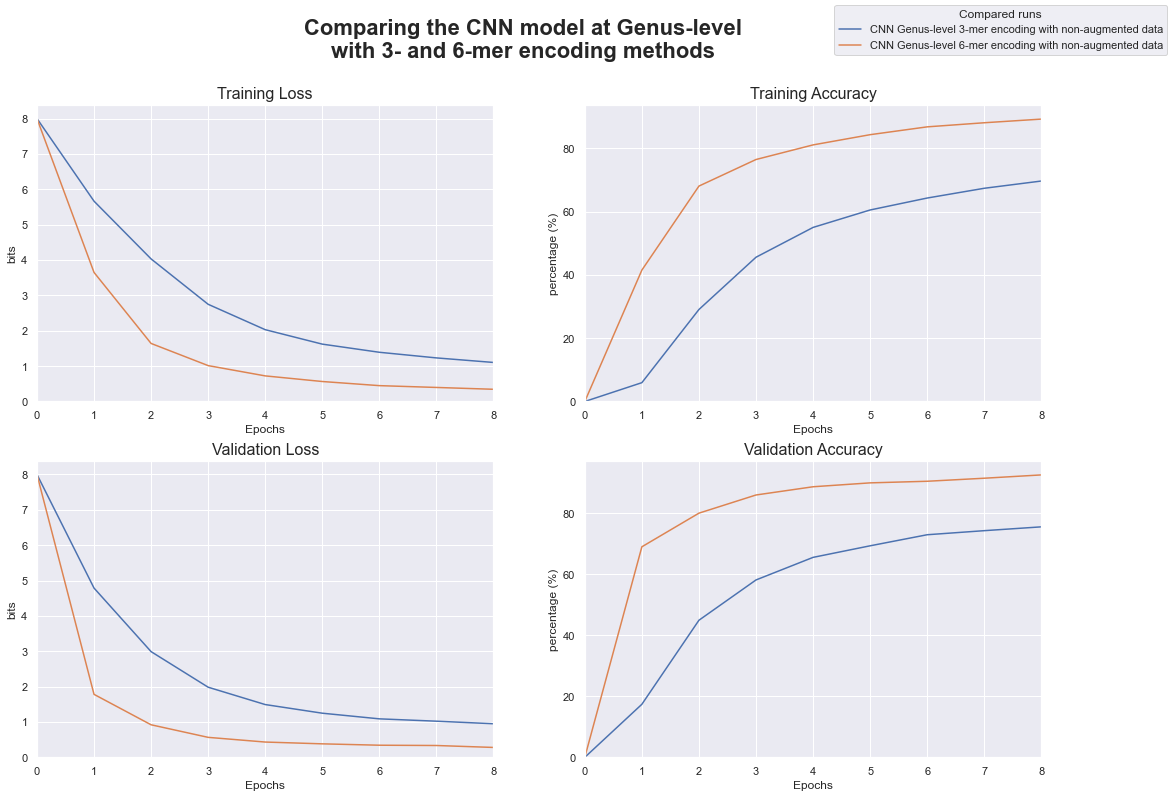

In [121]:
plot_hist(histories_CNN_processing_genus, suptitle='Comparing the CNN model at Genus-level\nwith 3- and 6-mer encoding methods', epochs=8)

Comparing the BiLSTM model at Genus level with regular and mutation rate adjusted one-hot-encoding

In [ ]:
plot_hist(histories_BiLSTM_processing_genus, suptitle='Comparing the BiLSTM with regular and mutation rate adjusted one-hot-encoding')

Comparing the ConvBiLSTM model at Genus level with regular and mutation rate adjusted one-hot-encoding

In [ ]:
plot_hist(histories_ConvBiLSTM_processing_genus, suptitle='Comparing the ConvBiLSTM with regular and mutation rate adjusted one-hot-encoding')

Comparing the R2P model at Genus level with regular and mutation rate adjusted one-hot-encoding

In [ ]:
plot_hist(histories_R2P_processing_genus, suptitle='Comparing Read2Pheno with regular and mutation rate adjusted one-hot-encoding')

#### Comparing the models' results at different taxon levels
Comparing the CNN model at Family, Genus and Species level

C:\Users\robbe\AppData\Local\Temp/ipykernel_15308/309706725.py:78: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


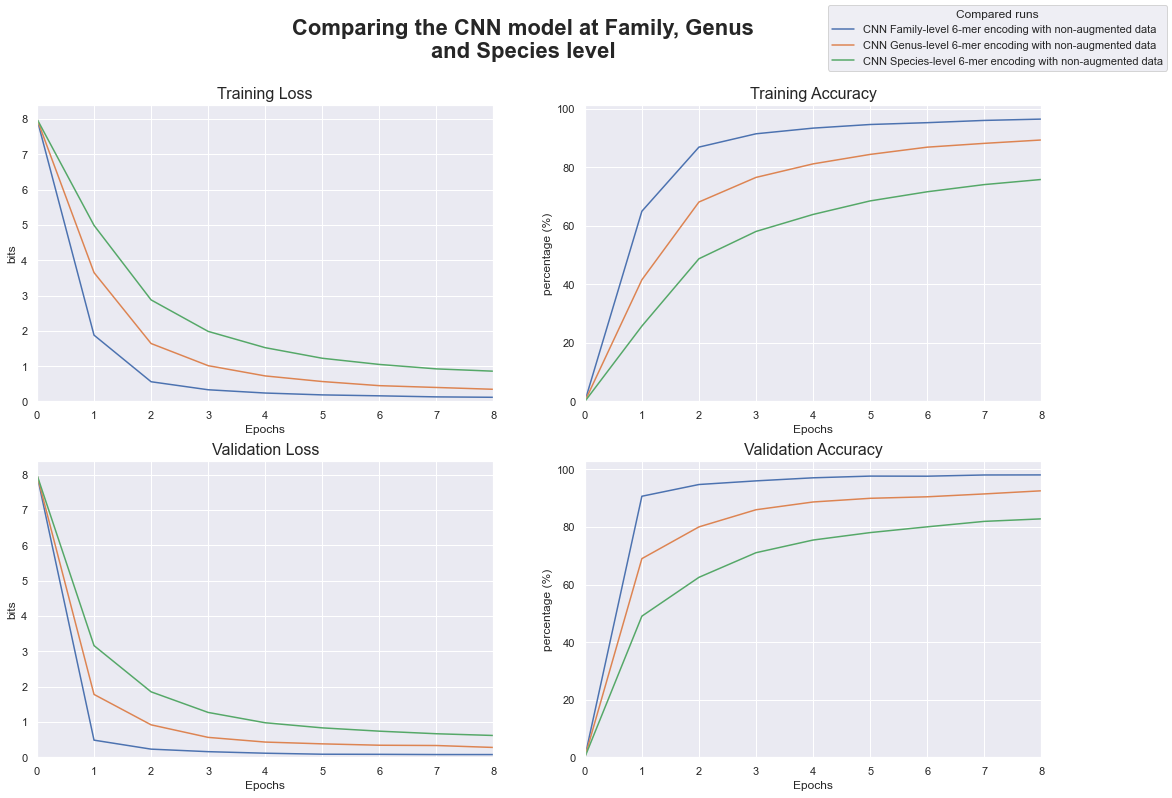

In [123]:
plot_hist(histories_CNN_fam_gen_spe, suptitle='Comparing the CNN model at Family, Genus\nand Species level', epochs=8)

Comparing the BiLSTM model at Family, Genus and Species level

In [ ]:
plot_hist(histories_BiLSTM_fam_gen_spe, suptitle='Comparing the BiLSTM at Family, Genus and Species level')

Comparing the ConvBiLSTM model at Family, Genus and Species level

In [ ]:
plot_hist(histories_ConvBiLSTM_fam_gen_spe, suptitle='Comparing the ConvBiLSTM at Family, Genus and Species level')

Comparing the R2P model at Family, Genus and Species level

In [ ]:
plot_hist(histories_R2P_fam_gen_spe, suptitle='Comparing Read2Pheno at Family, Genus and Species level')

#### Comparing the models' results with the non-augmented and augmented data
Comparing the CNN model with the non-augmented and augmented data

In [ ]:
plot_hist(histories_CNN_na, suptitle='Comparing the CNN with non-augmented and augmented data')

Comparing the BiLSTM model with the non-augmented and augmented data

In [ ]:
plot_hist(histories_BiLSTM_na, suptitle='Comparing the BiLSTM with non-augmented and augmented data')

Comparing the ConvBiLSTM model with the non-augmented and augmented data

In [ ]:
plot_hist(histories_ConvBiLSTM_na, suptitle='Comparing the ConvBiLSTM with non-augmented and augmented data')

Comparing the R2P model with the non-augmented and augmented data

In [ ]:
plot_hist(histories_R2P_na, suptitle='Comparing Read2Pheno with non-augmented and augmented data')

#### Comparing the models to each other

In [ ]:
plot_hist(histories_models, suptitle='Comparing the four Deep Learning models')